# Popularity based recommendation model

## Part 1. Import libraries and dataset

In [1]:
import pandas as pd 
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

In [2]:
retail_data_original = pd.read_excel (r'D:/Internship-2020/ROBOKEN-internship/Recommendation-system/Datset/Online Retail Original.xlsx')

## Part 2. Cleaning and processing of the data

In [3]:
retail_data = retail_data_original
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,Date,Time,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2010-12-01,08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2010-12-01,08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,2010-12-01,08:26:00,3.39,17850.0,United Kingdom


There might be mising values present in the dataset, therefore we have to find the count of values from each column. After running the cell given below we found that CustomerID column has 406829 values as compared to 541909 values. 

Hence we will delete the rows where there is no value given in CustomerID section.

In [4]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   Date         541909 non-null  datetime64[ns]
 6   Time         541909 non-null  object        
 7   UnitPrice    541909 non-null  float64       
 8   CustomerID   406829 non-null  float64       
 9   Country      541909 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 41.3+ MB


## Part 3. Item lookup table

This is a table where the Name of item is marked against its StockCode. It is useful for seeing what recommendations has been suggested

In [5]:
item_lookup = retail_data[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) # Encode as strings for future lookup ease

In [6]:
item_lookup.head() # Sample table

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [7]:
item_lookup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5752 entries, 0 to 540421
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StockCode    5752 non-null   object
 1   Description  4792 non-null   object
dtypes: object(2)
memory usage: 134.8+ KB


## Part 4. Grouping purchase (Day-wise) and cleaning null values

#### Steps:
    1. Convert the string for stock ID
    2. Reduce unnecessary columns
    3. In case of zero purchase, update the value with 1 as it might be possible that someone has replaced it. Hence, we want to focus only on the purchase
    4. For negative quantity, discard them

In [8]:
retail_data['StockCode'] = retail_data.StockCode.astype(str) # Convert to string for stock ID
retail_data = retail_data[['StockCode', 'Quantity', 'Time', 'Date','InvoiceDate']] # Get rid of unnecessary info
grouped_retail_buy_frequency = retail_data.groupby(['StockCode','Date']).sum().reset_index() # Group together
grouped_retail_buy_frequency.Quantity.loc[grouped_retail_buy_frequency.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
grouped_purchased = grouped_retail_buy_frequency.query('Quantity > 0') # Only get customers where purchase totals were positive

C:\Users\test\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
grouped_purchased.head() # Grouped data according to item sold per day

,StockCode,Date,Quantity
0,10002,2010-12-01,60
1,10002,2010-12-02,1
2,10002,2010-12-03,8
3,10002,2010-12-05,1
4,10002,2010-12-06,25


# Part 5. Models

# a. Basic popularity based recommendation

For basic popularity based recommendation model, we just need the item and quantity sold. 

In [10]:
retail_data_new = grouped_purchased[['StockCode', 'Quantity']] # Get rid of unnecessary info
retail_data_new

,StockCode,Quantity
0,10002,60
1,10002,1
2,10002,8
3,10002,1
4,10002,25
...,...,...
280446,gift_0001_50,1
280447,gift_0001_50,1
280448,gift_0001_50,1
280449,gift_0001_50,1


Calculating total units sold per item

In [11]:
retail_data_units_sold = retail_data_new.groupby(['StockCode']).sum().reset_index()
retail_data_units_sold

,StockCode,Quantity
0,10002,1040
1,10080,495
2,10120,193
3,10123C,5
4,10124A,16
...,...,...
3934,gift_0001_20,20
3935,gift_0001_30,37
3936,gift_0001_40,3
3937,gift_0001_50,4


Sort them on the basis of quantity sold

In [12]:
df = retail_data_units_sold
df_popular = df.sort_values(by=['Quantity'], ascending = False)

#### Sales plot

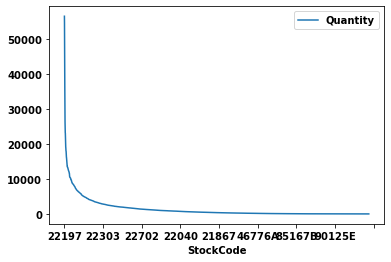

In [13]:
df_popular.plot(kind='line',x='StockCode',y='Quantity')
plt.show()

Convert to matrix

In [14]:
df_popular_numpy = np.array(df_popular)
df_popular_numpy[1][0]

'84077'

## Function: Output for top # popular items

#### Recommedation function

In [15]:
def rec_items( df, item_lookup, num_items = '10'):
    rec_list = []
    for i in range(num_items):
        code = df[i][0]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]]) #add item description to the array using lookup table provided in the start
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions}) # Create a dataframe 
    print('Here are the top recommendations for you:')
    return final_frame[['StockCode', 'Description']] # Switch order of columns around
    #return rec_list

##### Steps:

1. Enter the number of top recommendation you want
2. Press Shift + Enter

In [16]:
Num = int(input('Enter the number of top popular recommendations you want: ')) #Step 1
rec_items(df_popular_numpy, item_lookup, Num)

Enter the number of top popular recommendations you want: 10
Here are the top recommendations for you:


,StockCode,Description
0,22197,SMALL POPCORN HOLDER
1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
2,85099B,JUMBO BAG RED RETROSPOT
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER
4,84879,ASSORTED COLOUR BIRD ORNAMENT
5,21212,PACK OF 72 RETROSPOT CAKE CASES
6,23084,RABBIT NIGHT LIGHT
7,22492,MINI PAINT SET VINTAGE
8,22616,PACK OF 12 LONDON TISSUES
9,21977,PACK OF 60 PINK PAISLEY CAKE CASES


# b. Popular since last # number of days

This recommendation model suggests popular products which are purchased the most in last n number of days. For this, item number, date of purchase and quantity of purchase is taken into consideration.

In [17]:
retail_data_V2 = retail_data[['StockCode', 'Quantity', 'Date']] # Get rid of unnecessary info
retail_data_V2

,StockCode,Quantity,Date
0,85123A,6,2010-12-01
1,71053,6,2010-12-01
2,84406B,8,2010-12-01
3,84029G,6,2010-12-01
4,84029E,6,2010-12-01
...,...,...,...
541904,22613,12,2011-12-09
541905,22899,6,2011-12-09
541906,23254,4,2011-12-09
541907,23255,4,2011-12-09


#### Sales in last # number of days

The function given below gives out sales matrix of last # number of days. The input required are:
1. df - Sales data (here, retail_data_V2)
2. num_days - number of days sales we want to consider

In [18]:
def last_n_days_sale(df, num_day):
    rows = len(df) # number of entries in the dataframe
    end_date = df.iat[rows-1,2] # latest date
    delta = timedelta(days=num_day)
    start_date = end_date - delta
    print("The record is being displayed for products bought between ("+ str(start_date) + ") and ("+ str(end_date) + ")")
    
    # segregating the day, month and year of the 
    start_day = start_date.day
    start_month = start_date.month
    start_year = start_date.year
    print(start_day, start_month, start_year)
    end_day = end_date.day
    end_month = end_date.month
    end_year = end_date.year
    
    
    #Slicing the dataset after the start date
    df2 = df[(df.Date >= datetime(start_year, start_month, start_day)) &
             (df.Date <= datetime(end_year, end_month, start_day))]
    
    # Grouping quanity
    df2 = df2.groupby(['StockCode']).sum().reset_index()
    
    df2.Quantity.loc[grouped_retail_buy_frequency.Quantity == 0] = 1 # Replace a sum of zero purchases with a one to
    # indicate purchased
    df2 = df2.query('Quantity > 0') # Only get customers where purchase totals were positive
    df2_popular = df2.sort_values(by=['Quantity'], ascending = False)
    
    df2_popular.plot(kind='line',x='StockCode',y='Quantity')
    plt.show()
    
    new = np.array(df2_popular)
    return new

# Function: Output for top # popular items for last # days

#### Steps
1. Enter the number of days' sales you want to take into the consideration
2. Enter the number of recommendations you want
3. Press Enter

Enter the number of days recommendation you want: 42
Enter the number of top popular recommendations you want: 10
The record is being displayed for products bought between (2011-10-28 00:00:00) and (2011-12-09 00:00:00)
28 10 2011


C:\Users\test\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


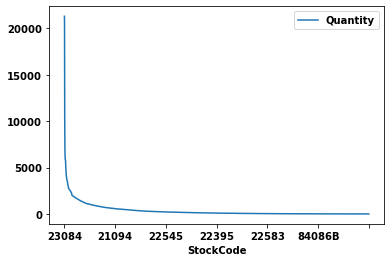

Here are the top recommendations for you:


,StockCode,Description
0,23084,RABBIT NIGHT LIGHT
1,22197,SMALL POPCORN HOLDER
2,84826,ASSTD DESIGN 3D PAPER STICKERS
3,22086,PAPER CHAIN KIT 50'S CHRISTMAS
4,85099B,JUMBO BAG RED RETROSPOT
5,84879,ASSORTED COLOUR BIRD ORNAMENT
6,20668,DISCO BALL CHRISTMAS DECORATION
7,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
8,85123A,WHITE HANGING HEART T-LIGHT HOLDER
9,22578,WOODEN STAR CHRISTMAS SCANDINAVIAN


In [19]:
Num_days = int(input('Enter the number of days recommendation you want: ')) #Step 1
Num = int(input('Enter the number of top popular recommendations you want: ')) #Step 2
new = last_n_days_sale(retail_data_V2, Num_days)
rec_items(new, item_lookup, Num)

# c. Weighted averaged recommendation

Group the sales according to the date i.e. units sold datewise
##### #Reference table 1

In [20]:
grouped_retail_buy_frequency_date = retail_data.groupby(['Date','StockCode',]).sum().reset_index() # Group together
grouped_purchased_date = grouped_retail_buy_frequency_date.query('Quantity > 0') # Only get customers where purchase totals were positive
grouped_purchased_date

,Date,StockCode,Quantity
0,2010-12-01,10002,60
1,2010-12-01,10125,2
2,2010-12-01,10133,5
3,2010-12-01,10135,1
4,2010-12-01,11001,3
...,...,...,...
280445,2011-12-09,90206C,1
280446,2011-12-09,90208,1
280447,2011-12-09,90210A,1
280448,2011-12-09,DOT,2


#### Calculation of total number of days

In [21]:
rows = len(grouped_purchased_date)
end_date = grouped_purchased_date.iat[rows-1,0] # Last date of purchase
start_date = grouped_purchased_date.iat[0,0] # First date of purchase
delta = end_date - start_date + timedelta(days=1) # difference
total_days = delta.days
print('Total days record found:',total_days)

Total days record found: 374


#### Number of items

Grouping according to the items sold 
##### #Reference table 2

In [22]:
retail_data_num = retail_data[['StockCode', 'Quantity']] # Get rid of unnecessary info
grouped_retail_buy_frequency_num = retail_data_num.groupby(['StockCode',]).sum().reset_index() # Group together
grouped_retail_buy_frequency_num

,StockCode,Quantity
0,10002,1037
1,10080,495
2,10120,193
3,10123C,-13
4,10123G,-38
...,...,...
4065,gift_0001_20,20
4066,gift_0001_30,37
4067,gift_0001_40,3
4068,gift_0001_50,4


Total number of items

In [23]:
stock_num = len(grouped_retail_buy_frequency_num)
print('Total number of items found are:',stock_num)

Total number of items found are: 4070


### Purchase matrix

This is a 2D matrix which displays Item Vs date sales.

Here number of items are 4070 and days are 374

In [24]:
purchase_matrix = np.array([[0 for k in range(total_days)]for j in range(stock_num)]) #initialization of matrix
purchase_matrix.shape

(4070, 374)

##### Converting to purchase matrix

In [25]:
new_date = start_date
SC_Index = 0 # for tracking product index (grouped_purchased)
SC_Index_date = 0
print('Starting indexing...')
for i in range(purchase_matrix.shape[0]):
    value = grouped_retail_buy_frequency_num.iat[i,0]
    new_date_n = new_date
    for j in range(purchase_matrix.shape[1]):
        #print('SC_Index and j',SC_Index, j)
        #print('Matrix data',i,j-1,purchase_matrix[i,j-1])
        if grouped_purchased.iat[SC_Index,0] == value:
            #print(value)
            #print(i,j,purchase_matrix[i,j])
            #print('DateCheck',grouped_purchased.iat[SC_Index,1],new_date_n)
            if grouped_purchased.iat[SC_Index,1] != new_date_n:
                purchase_matrix[i,j] = 0
                new_date_n = new_date_n + timedelta(days=1)
                #print('SC_Index: ', SC_Index)                           
            elif grouped_purchased.iat[SC_Index,1] == new_date_n:
                purchase_matrix[i,j] = grouped_purchased.iat[SC_Index,2]
                #print(i,j,purchase_matrix[i,j])
                new_date_n = new_date_n + timedelta(days=1)
                SC_Index += 1
        else:
            pass
        if SC_Index > len(grouped_purchased)-1: 
            print('Indexing complete!')
            break

Starting indexing...
Indexing complete!


Run next cell if you want to save the purchase matrix as csv

In [26]:
np.savetxt('data.csv', purchase_matrix, delimiter=',')

## Creating weight function

The weight function selected is rescaled normal ditribution function as shown in the graph below. 

The default value for weight decrement is upto 75% and till 100 days the weights gradually fall. 

1. Till 365 days - Rescaled normal distribution function which ends at 75%
2. After 365 days - 75% 

In [27]:
def weight_func(SD = 10, percentile = 0.75):
    x_axis = np.arange(0, 36.5, 0.1)
    # Mean = 0, SD = 2.
    y = norm.pdf(x_axis,0,SD)
    y = np.array(y)
    
    #scaling the function
    mn = min(y)
    mx = max(y)
    diff = mx - mn
    p = (1-percentile)/percentile
    scale = (mx)/(mn*p)

    y_new = y - mn
    y_new = y_new/scale
    y_new = y_new + mn
    y_new = y_new/max(y_new)
    plt.plot(x_axis,y_new)
    return y_new

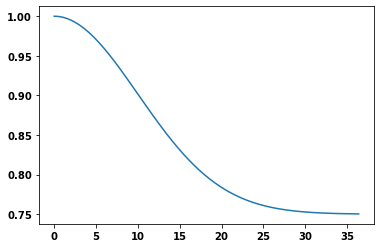

In [28]:
arr = weight_func() #input SD and percent decrease accordingly. The default value is chosen for 100 days for standard deviation and 75% for decrease 

Assigning weightage of 75% after 365 days

In [29]:
def weight_matrix(purchase_matrix, arr):
    length = purchase_matrix.shape[1]
    diff = length - 365 
    for i in range(diff):
        arr = np.append(arr,[0.75], axis =None)
    return arr

In [30]:
array = weight_matrix(purchase_matrix, arr)

In [31]:
array = array.reshape(array.shape[0],1)

## Applying new weights to purchase matrix

In [32]:
def out(array, purchase_matrix):
    array = array.transpose()
    output = purchase_matrix*array
    return output

In [33]:
purchase_matrix_final = out(array, purchase_matrix)
purchase_matrix_final.shape

(4070, 374)

In [34]:
Quantity = np.sum(purchase_matrix_final, axis=1)
Quantity_ = pd.DataFrame(Quantity)
Quantity_.columns = ['Quantity']

adding final output with Item descriptions

In [35]:
df = grouped_retail_buy_frequency_num.loc[:,'StockCode']

In [36]:
Quantity_.insert(0, "StockCode", df, True) 

In [37]:
Quantity_

,StockCode,Quantity
0,10002,973.905434
1,10080,377.509178
2,10120,159.375062
3,10123C,4.608196
4,10123G,0.000000
...,...,...
4065,gift_0001_20,16.373161
4066,gift_0001_30,28.606272
4067,gift_0001_40,2.626017
4068,gift_0001_50,3.375424


Sorting according to the number of purchase made

In [38]:
df = Quantity_
df_popular = df.sort_values(by=['Quantity'], ascending = False)

In [39]:
new= np.array(df_popular)

# Function: Recommendation after applying weights

In [40]:
Num = int(input('Enter the number of top popular recommendations you want: ')) #Step 1
rec_items(new, item_lookup, Num)

Enter the number of top popular recommendations you want: 10
Here are the top recommendations for you:


,StockCode,Description
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
1,22197,SMALL POPCORN HOLDER
2,85099B,JUMBO BAG RED RETROSPOT
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER
4,21212,PACK OF 72 RETROSPOT CAKE CASES
5,84879,ASSORTED COLOUR BIRD ORNAMENT
6,23084,RABBIT NIGHT LIGHT
7,22616,PACK OF 12 LONDON TISSUES
8,22492,MINI PAINT SET VINTAGE
9,21977,PACK OF 60 PINK PAISLEY CAKE CASES
